In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix
from scripts_tempHelix import generate_static_temporal_helix
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

In [2]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_static_temporal_helix(rep))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def theoretical_hitting_time(n,factor,c):
    hitting_times = []
    for i in n:
        hitting_times.append(c*i**factor)
       
    return hitting_times

In [3]:
reps = 30

sum_range = []
samples = 200

sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

initVertex = 0
targetVertex = -1

factor = 2
c = 0.85

hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = theoretical_hitting_time(sum_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = estimate_hitting_time(reps,initVertex,targetVertex,samples)
    theoretical_hitting_times = theoretical_hitting_time(sum_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times)



[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]
Looking for: 
-----> Datasets/DynGraphsDTRW/hittingTimeStaticTempHelix_N90_FROM0-TO-1_S200.txt

File exists!


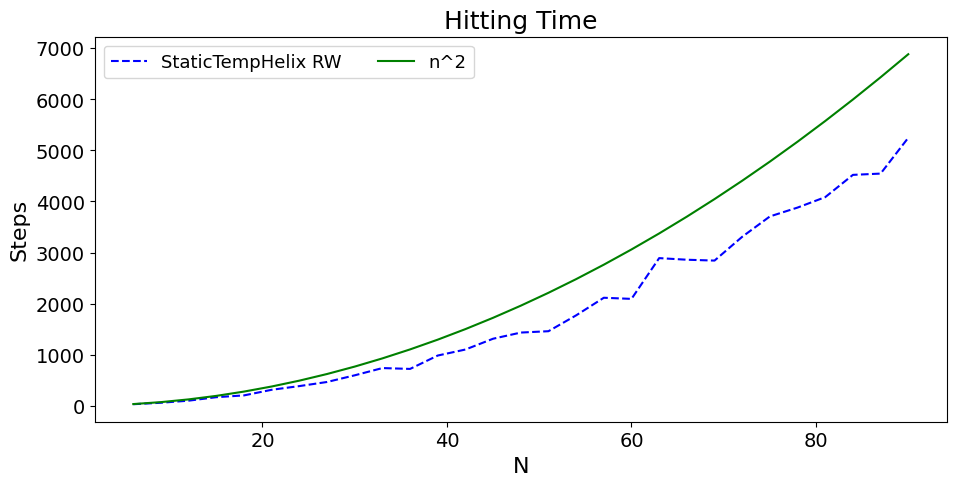

In [4]:
alphaLabelList = [r'StaticTempHelix RW',f'n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,theoretical_hitting_times],**params)

## Fitting the data

In [5]:
# Assume x_data and y_data are your data
x_data = sum_range
y_data = hitting_times

# Take the logarithm of your data
log_x = np.log10(x_data)
log_y = np.log10(y_data)

# Reshape your data because sklearn requires it to be in this format
log_x = log_x.reshape(-1, 1)
log_y = log_y.reshape(-1, 1)

# Create a LinearRegression object
reg = LinearRegression()

# Fit the model to your data
reg.fit(log_x, log_y)

# Now, your value of c is:
constant = 10 ** reg.intercept_

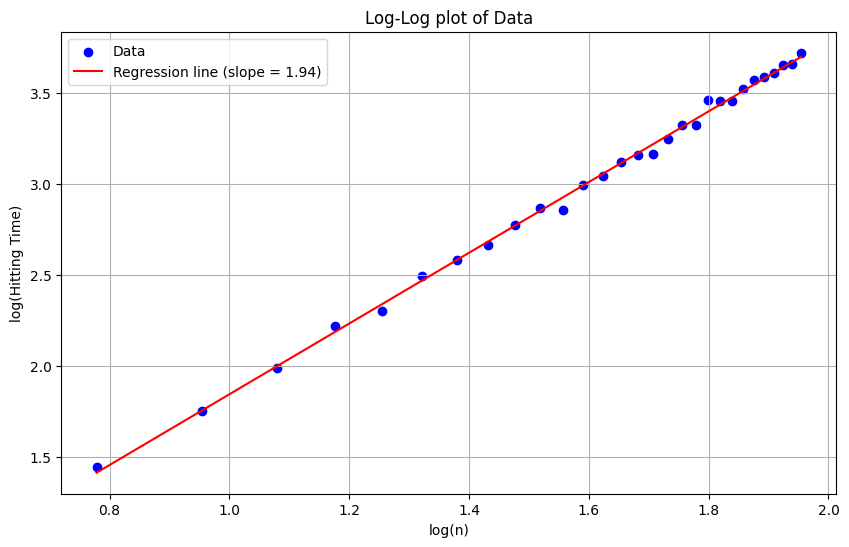

In [6]:
def plot_loglog(x_data, y_data):
    # Take the logarithm of your data
    log_x = np.log10(x_data)
    log_y = np.log10(y_data)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, color='blue', label='Data')

    # Add a regression line
    slope, intercept = np.polyfit(log_x, log_y, 1)
    plt.plot(log_x, slope*log_x + intercept, color='red', label=f'Regression line (slope = {slope:.2f})')

    # Add labels and legend
    plt.xlabel('log(n)')
    plt.ylabel('log(Hitting Time)')
    plt.title('Log-Log plot of Data')
    plt.legend()
    plt.grid(True)
    plt.show()
    return slope

# Assume x_data and y_data are your data
slope = plot_loglog(x_data, y_data)

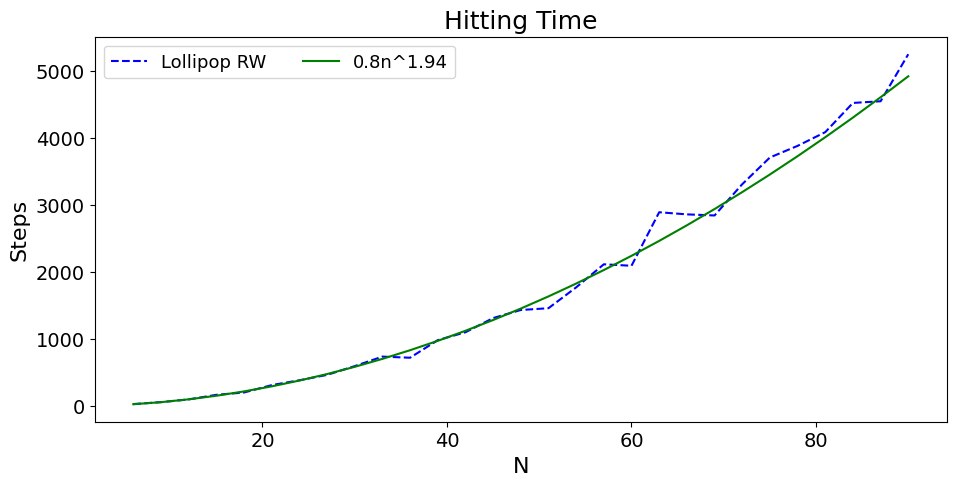

In [7]:
c = constant[0]
factor = round(slope,2)

estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]


alphaLabelList = [r'Lollipop RW',f'{round(c,2)}n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,estimate_cover_time_memory],**params)

## Theoretical Hitting Time

In [8]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
def expected_hitting_time(P, q, z):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states

    # Create the modified transition matrix P_{-z}
    P_minus_z = P.copy()
    P_minus_z[:, z] = 0  # zero the column corresponding to z
    P_minus_z[z, :] = 0  # zero the row corresponding to z
    # Create the modified initial state distribution q_{-z}
    q_minus_z = q.copy()
    q_minus_z[z] = 0  # zero the element corresponding to z

    # Create the identity matrix
    I = np.eye(n)

    # Calculate the inverse of (I - P_{-z})
    inv = np.linalg.inv(I - P_minus_z)

    # Calculate the expected hitting time from state q to state z
    h_z_q = np.dot(q_minus_z, np.dot(inv, np.ones(n)))

    return h_z_q

def hitting_times_for_staticTempHelix_graphs(reps, initIndex, target):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            init = np.zeros(len(G))
            init[initIndex] = 1
            P = create_transition_matrix(G)
            hitting_time = expected_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

reps = 30

init = 0
target = -1

theoretical_hitting_times2 = hitting_times_for_staticTempHelix_graphs(reps, init, target)


[36, 81, 144, 225, 324, 441, 576, 729, 900, 1089, 1296, 1521, 1764, 2025, 2304, 2601, 2916, 3249, 3600, 3969, 4356, 4761, 5184, 5625, 6084, 6561, 7056, 7569, 8100]
[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]


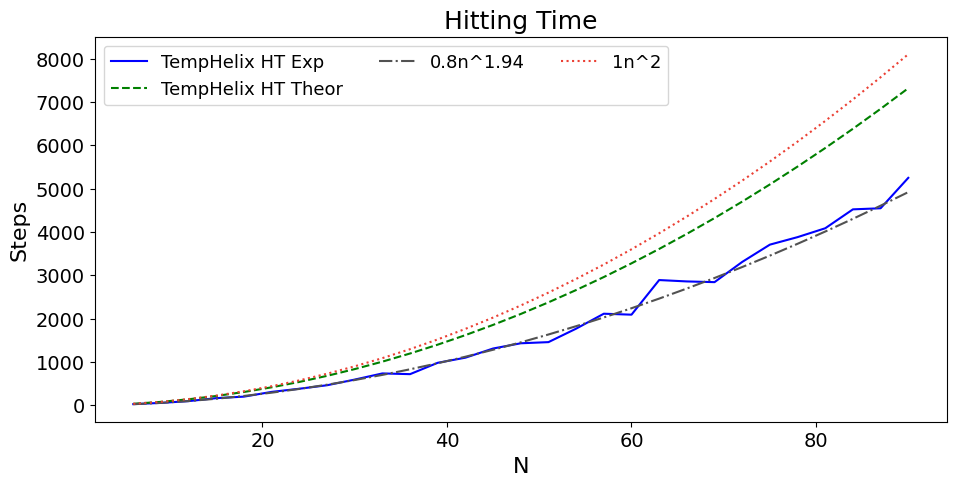

In [9]:
c = constant[0]
factor = round(slope,2)
c2 = 1
factor2 = 2

alphaLabelList = [r'TempHelix HT Exp',f'TempHelix HT Theor',f'{round(c,2)}n^{factor}',f'{round(c2,2)}n^{factor2}']



estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]
estimate_cover_time_memory2 = [x for x in theoretical_hitting_time(sum_range,factor2,c2)]
print(estimate_cover_time_memory2)
print(list(sum_range))

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034'],
    'line_style_list' : ['-', '--','-.',':' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range)]*4 , y_value_matrix = [hitting_times,theoretical_hitting_times2,estimate_cover_time_memory,estimate_cover_time_memory2],**params)

## Theoretical Hitting Times V2


In [10]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
def theoretical_hitting_time3(P, init, target, steps):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    print(n)

    # Create the modified transition matrix P_{-z}
    P_prime = P.copy()
    # print_matrix(P_prime)
    # print()
    P_prime[target,:] = 0
    P_prime[target,target] = 1
    # print_matrix(P_prime)
    # print()
    # P_minus_z[:, z] = 0  # zero the column corresponding to z
    # P_minus_z[z, :] = 0  # zero the row corresponding to z
    
    init_dist = np.zeros(n)
    init_dist[init] = 1
    # print(init_dist)
    
    target_dist = np.ones(n)
    target_dist[target] = 0
    target_dist = target_dist
    # print(target_dist)

    # Create the identity matrix
    I = np.eye(n)

    # Calculate the inverse of (I - P_{-z})
    # inv = np.linalg.inv(I - P_minus_z)
    # print(np.dot(P_prime, target_dist))
    # Calculate the expected hitting time from state q to state z
    hitting_time = np.dot(init_dist, np.dot(np.linalg.matrix_power(P_prime,1), target_dist))
    for t in range(2,steps):
        hitting_time+=np.dot(init_dist, np.dot(np.linalg.matrix_power(P_prime,t), target_dist))

    return hitting_time

def theoretical_hitting_times3_for_staticTempHelix_graphs(reps, init, target,steps):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            P = create_transition_matrix(G)
            hitting_time = theoretical_hitting_time3(P, init, target,steps)
            hitting_times.append(hitting_time)
    return hitting_times

In [11]:
reps = 30

init = 0
target = -1
steps = 10000

sum_range = []
sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

factor = 2
c = 0.85

theoretical_hitting_times_file3 = f'Datasets/DynGraphsDTRW/theoreticalHitting3TimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_STEPS{steps}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file3}')

if os.path.exists(theoretical_hitting_times_file3):
    theoretical_hitting_times3 = load_list_from_file(theoretical_hitting_times_file3)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times3 =  theoretical_hitting_times3_for_staticTempHelix_graphs(reps, init, target,steps)
    write_list_to_file(theoretical_hitting_times_file3, theoretical_hitting_times3)

[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]
Looking for: 
-----> Datasets/DynGraphsDTRW/theoreticalHitting3TimeStaticTempHelix_N90_FROM0-TO-1_STEPS10000.txt

File exists!


[34.999999999999936, 78.99999999999972, 138.99999999999875, 214.99999999999838, 306.9999999999964, 414.999999999932, 538.9999999238513, 678.9999898960382, 834.9996432082886, 1006.9947561081196, 1194.957882060872, 1398.7800775238343, 1618.162399910745, 1852.4824695875907, 2100.6882043375167, 2361.262183796056, 2632.2678128849066, 2911.4585426984777, 3196.4179206593403, 3484.7000764134355, 3773.949906223203, 4061.993006525398, 4346.89380051131, 4626.985403741356, 4900.87707347381, 5167.445495397734, 5425.81552491913, 5675.33492495761, 5915.546497225804]


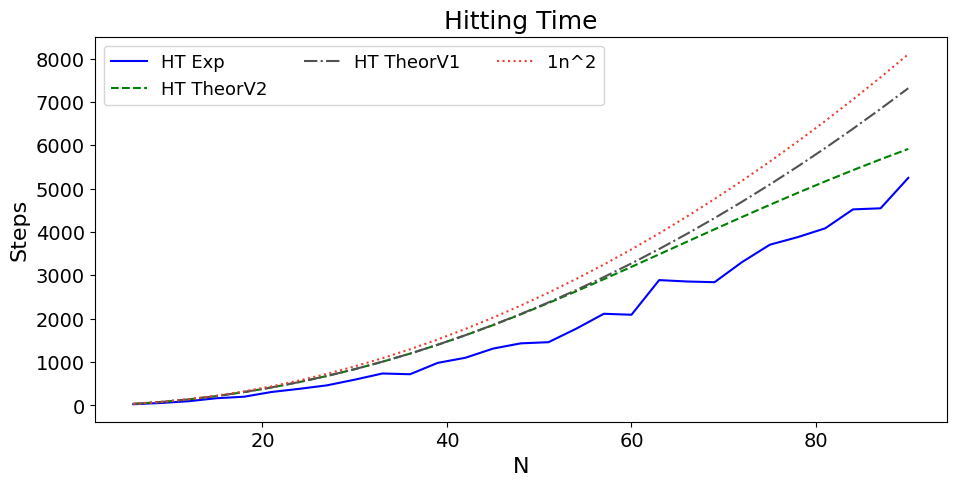

In [12]:
c = constant[0]
factor = round(slope,2)
c2 = 1
factor2 = 2

alphaLabelList = [r'HT Exp',f'HT TheorV2',f'HT TheorV1',f'{round(c2,2)}n^{factor2}']



estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]
estimate_cover_time_memory2 = [x for x in theoretical_hitting_time(sum_range,factor2,c2)]
# print(estimate_cover_time_memory2)
# print(list(sum_range))
print(theoretical_hitting_times3
)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034'],
    'line_style_list' : ['-', '--','-.',':' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range)]*4 , y_value_matrix = [hitting_times,theoretical_hitting_times3,theoretical_hitting_times2,estimate_cover_time_memory2],**params)

In [13]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
def theoretical_hitting_time4(P, init, target, steps):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    print(n)

    # Create the modified transition matrix P_{-z}
    P_prime = P.copy()
    # print_matrix(P_prime)
    # print()
    P_prime[target,:] = 0
    P_prime[target,target] = 1
    # print_matrix(P_prime)
    # print()
    # P_minus_z[:, z] = 0  # zero the column corresponding to z
    # P_minus_z[z, :] = 0  # zero the row corresponding to z
    
    init_dist = np.zeros(n)
    init_dist[init] = 1
    # print(init_dist)
    
    target_dist = np.ones(n)
    target_dist[target] = 0
    target_dist = target_dist
    # print(target_dist)

    # Create the identity matrix
    I = np.eye(n)

    # Calculate the inverse of (I - P_{-z})
    # inv = np.linalg.inv(I - P_minus_z)
    # print(np.dot(P_prime, target_dist))
    # Calculate the expected hitting time from state q to state z
    
    P_prime_t = np.zeros((n,n))
    for t in range(0,steps):
        P_prime_t += np.linalg.matrix_power(P_prime,t)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_t, target_dist))

    return hitting_time

def theoretical_hitting_times4_for_staticTempHelix_graphs(reps, init, target,steps):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            P = create_transition_matrix(G)
            hitting_time = theoretical_hitting_time4(P, init, target,steps)
            hitting_times.append(hitting_time)
    return hitting_times


In [14]:
reps = 30

init = 0
target = -1
steps = 20000

sum_range = []
sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

factor = 2
c = 0.85

theoretical_hitting_times_file4 = f'Datasets/DynGraphsDTRW/theoreticalHitting4TimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_STEPS{steps}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file4}')

if os.path.exists(theoretical_hitting_times_file4):
    theoretical_hitting_times4 = load_list_from_file(theoretical_hitting_times_file4)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times4 =  theoretical_hitting_times4_for_staticTempHelix_graphs(reps, init, target,steps)
    write_list_to_file(theoretical_hitting_times_file4, theoretical_hitting_times4)

[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]
Looking for: 
-----> Datasets/DynGraphsDTRW/theoreticalHitting4TimeStaticTempHelix_N90_FROM0-TO-1_STEPS20000.txt

File exists!


[34.999999999999936, 78.99999999999972, 138.99999999999875, 214.99999999999838, 306.9999999999964, 414.999999999932, 538.9999999238513, 678.9999898960382, 834.9996432082886, 1006.9947561081196, 1194.957882060872, 1398.7800775238343, 1618.162399910745, 1852.4824695875907, 2100.6882043375167, 2361.262183796056, 2632.2678128849066, 2911.4585426984777, 3196.4179206593403, 3484.7000764134355, 3773.949906223203, 4061.993006525398, 4346.89380051131, 4626.985403741356, 4900.87707347381, 5167.445495397734, 5425.81552491913, 5675.33492495761, 5915.546497225804]


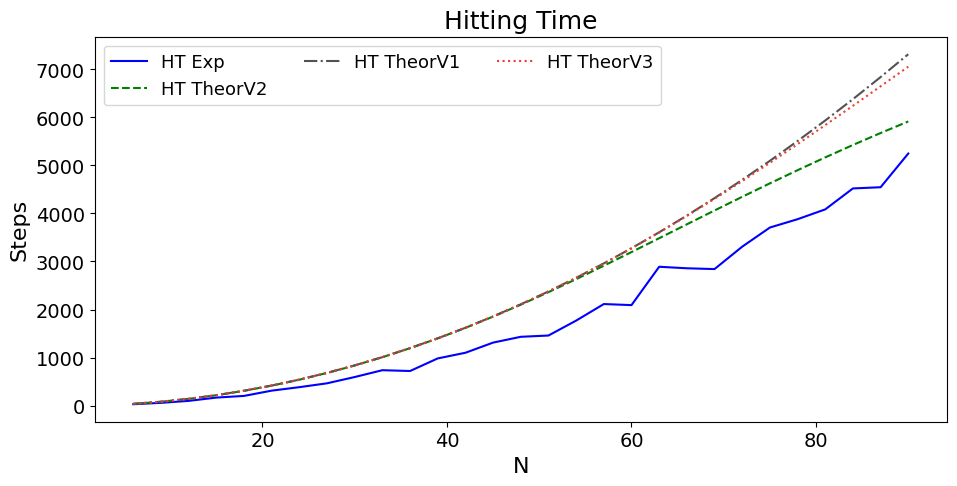

In [15]:
c = constant[0]
factor = round(slope,2)
c2 = 1
factor2 = 2

alphaLabelList = [r'HT Exp',f'HT TheorV2',f'HT TheorV1',f'HT TheorV3']



estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]
estimate_cover_time_memory2 = [x for x in theoretical_hitting_time(sum_range,factor2,c2)]
# print(estimate_cover_time_memory2)
# print(list(sum_range))
print(theoretical_hitting_times3
)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034'],
    'line_style_list' : ['-', '--','-.',':' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range)]*4 , y_value_matrix = [hitting_times,theoretical_hitting_times3,theoretical_hitting_times2,theoretical_hitting_times4],**params)

In [24]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
def remove_row_and_column(matrix,target):
    return matrix[:-1, :-1]

    
    return new_matrix
        
def theoretical_hitting_time5(P, init, target, steps):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    print(n)
    # print_matrix(P)
    # print()    
    # Create the modified transition matrix P_{-z}
    P_prime = P[:target, :target]
    # print_matrix(P_prime)
    # print()    

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
#     # print(init_dist)
    
    target_dist = np.ones(n-1)
    # target_dist = target_dist[:target]
    # print(target_dist)

    P_prime_t = np.zeros((n-1,n-1))
    for t in range(0,steps):
        P_prime_t += np.linalg.matrix_power(P_prime,t)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_t, target_dist))

    return hitting_time

def theoretical_hitting_times5_for_staticTempHelix_graphs(reps, init, target,steps):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            P = create_transition_matrix(G)
            hitting_time = theoretical_hitting_time5(P, init, target,steps)
            hitting_times.append(hitting_time)
    return hitting_times

In [25]:
reps = 30

init = 0
target = -1
steps = 20000

sum_range = []
sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

factor = 2
c = 0.85

theoretical_hitting_times_file5 = f'Datasets/DynGraphsDTRW/theoreticalHitting5TimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_STEPS{steps}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file5}')

if os.path.exists(theoretical_hitting_times_file5):
    theoretical_hitting_times5 = load_list_from_file(theoretical_hitting_times_file5)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times5 =  theoretical_hitting_times5_for_staticTempHelix_graphs(reps, init, target,steps)
    write_list_to_file(theoretical_hitting_times_file5, theoretical_hitting_times5)

[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]
Looking for: 
-----> Datasets/DynGraphsDTRW/theoreticalHitting5TimeStaticTempHelix_N90_FROM0-TO-1_STEPS20000.txt

File Doesnt Exist!
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90


[34.999999999999936, 78.99999999999972, 138.99999999999875, 214.99999999999838, 306.9999999999964, 414.999999999932, 538.9999999238513, 678.9999898960382, 834.9996432082886, 1006.9947561081196, 1194.957882060872, 1398.7800775238343, 1618.162399910745, 1852.4824695875907, 2100.6882043375167, 2361.262183796056, 2632.2678128849066, 2911.4585426984777, 3196.4179206593403, 3484.7000764134355, 3773.949906223203, 4061.993006525398, 4346.89380051131, 4626.985403741356, 4900.87707347381, 5167.445495397734, 5425.81552491913, 5675.33492495761, 5915.546497225804]


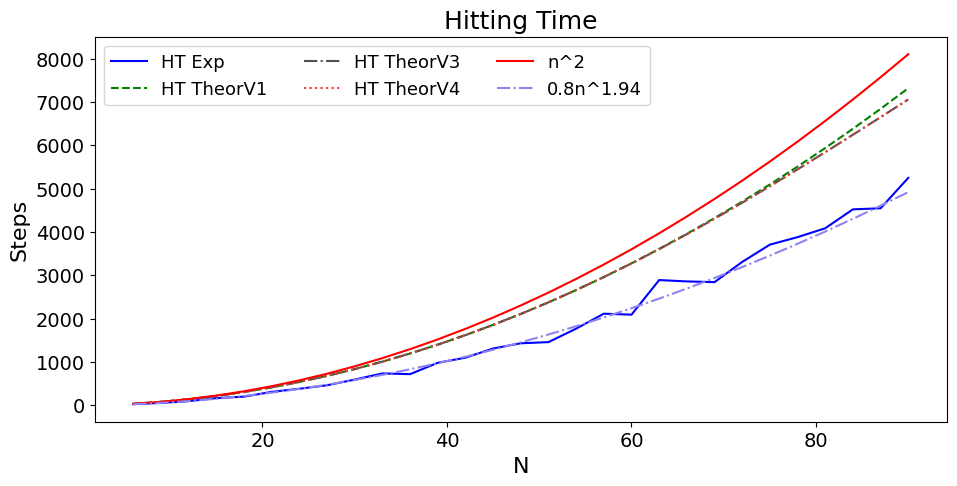

In [32]:
c = constant[0]
factor = round(slope,2)
c2 = 1
factor2 = 2

alphaLabelList = [r'HT Exp',f'HT TheorV1',f'HT TheorV3',f'HT TheorV4',f'n^2',f'{round(c,2)}n^{factor}']



estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]
estimate_cover_time_memory2 = [x for x in theoretical_hitting_time(sum_range,factor2,c2)]
# print(estimate_cover_time_memory2)
# print(list(sum_range))
print(theoretical_hitting_times3
)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034','red','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

y_value_list = [hitting_times,
                theoretical_hitting_times2,
                theoretical_hitting_times4,
                theoretical_hitting_times5,
                estimate_cover_time_memory2,
                estimate_cover_time_memory]

plot_qwak(x_value_matrix = [list(sum_range)]*6 , y_value_matrix = y_value_list ,**params)

In [36]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
def remove_row_and_column(matrix,target):
    return matrix[:-1, :-1]

    
    return new_matrix
        
def theoretical_hitting_time6(P, init, target, steps):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    print(n)
    # print_matrix(P)
    # print()    
    # Create the modified transition matrix P_{-z}
    P_prime = P[:target, :target]
    # print_matrix(P_prime)
    # print()    

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
#     # print(init_dist)
    
    target_dist = np.ones(n-1)
    # target_dist = target_dist[:target]
    # print(target_dist)
    # Create the identity matrix
    I = np.eye(n-1)

    # Calculate the inverse of (I - P_{-z})
    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_times6_for_staticTempHelix_graphs(reps, init, target,steps):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            P = create_transition_matrix(G)
            hitting_time = theoretical_hitting_time6(P, init, target,steps)
            hitting_times.append(hitting_time)
    return hitting_times

In [37]:
reps = 30

init = 0
target = -1
steps = 20000

sum_range = []
sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

factor = 2
c = 0.85

theoretical_hitting_times_file6 = f'Datasets/DynGraphsDTRW/theoreticalHitting6TimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_STEPS{steps}.txt'

print(f'Looking for: \n-----> {theoretical_hitting_times_file6}')

if os.path.exists(theoretical_hitting_times_file6):
    theoretical_hitting_times6 = load_list_from_file(theoretical_hitting_times_file6)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    theoretical_hitting_times6 =  theoretical_hitting_times6_for_staticTempHelix_graphs(reps, init, target,steps)
    write_list_to_file(theoretical_hitting_times_file6, theoretical_hitting_times6)

[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90]
Looking for: 
-----> Datasets/DynGraphsDTRW/theoreticalHitting6TimeStaticTempHelix_N90_FROM0-TO-1_STEPS20000.txt

File Doesnt Exist!
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90


[34.999999999999936, 78.99999999999972, 138.99999999999875, 214.99999999999838, 306.9999999999964, 414.999999999932, 538.9999999238513, 678.9999898960382, 834.9996432082886, 1006.9947561081196, 1194.957882060872, 1398.7800775238343, 1618.162399910745, 1852.4824695875907, 2100.6882043375167, 2361.262183796056, 2632.2678128849066, 2911.4585426984777, 3196.4179206593403, 3484.7000764134355, 3773.949906223203, 4061.993006525398, 4346.89380051131, 4626.985403741356, 4900.87707347381, 5167.445495397734, 5425.81552491913, 5675.33492495761, 5915.546497225804]


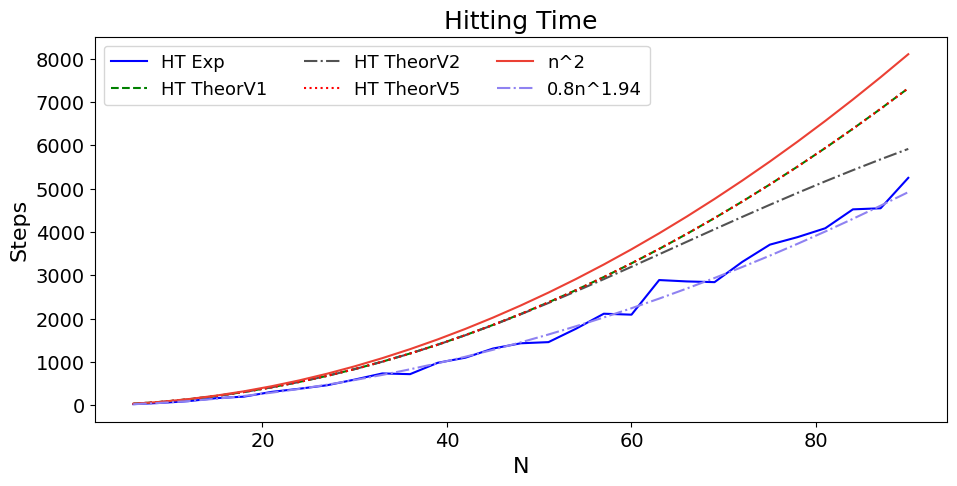

In [45]:
c = constant[0]
factor = round(slope,2)
c2 = 1
factor2 = 2

alphaLabelList = [r'HT Exp',f'HT TheorV1',f'HT TheorV2',f'HT TheorV5',f'n^2',f'{round(c,2)}n^{factor}']



estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]
estimate_cover_time_memory2 = [x for x in theoretical_hitting_time(sum_range,factor2,c2)]
# print(estimate_cover_time_memory2)
# print(list(sum_range))
print(theoretical_hitting_times3)

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

y_value_list = [hitting_times,
                theoretical_hitting_times2,
                theoretical_hitting_times3,
                theoretical_hitting_times6,
                estimate_cover_time_memory2,
                estimate_cover_time_memory]

plot_qwak(x_value_matrix = [list(sum_range)]*6 , y_value_matrix = y_value_list ,**params)